Project 2:

Name: Komal Ilyas

UIN: 432006386

---

 Import libraries:

In [46]:
import pickle
import os, shutil, pathlib
import random
from keras.models import load_model

Please Upload the data to this session. Then open the data using the following code:

In [47]:
path0 = pathlib.Path("/content/Train_input")
path1 = pathlib.Path("/content/Train_output")
# Uplaod
input=pickle.load(open(path0, 'rb'))
output=pickle.load(open(path1, 'rb'))

Pairs:

In [48]:
text_pairs = []
for inp,out in zip(input,output):
    out = "[start] " + out + " [end]"    # adding [start] and [end] to output language
    text_pairs.append((inp, out))

Sample:

In [49]:
# input[random.randint(0,5000)]
# len(input[random.randint(0,5000)])
# type(input)
# type(text_pairs)
# str(input)
# print(input[0:2])
# str1=str(input[0:2])
# print(str1)
print(random.choice(text_pairs))

('a h c d a e a e a g c d b d b d ', '[start] c d c d b d a g e f a e g a e h b d a h d i j  [end]')


Find the most common Vocab:

In [50]:
str1=str(output)
str1=str1.replace(']','')
str1=str1.replace('[','')
str1=str1.replace(',','')
unique_words = set(str1.split(' '))
print('unique_words = ',unique_words)
print('# of Vocab = ',len(unique_words))

unique_words =  {'d', 'f', "'", 'eh', 'j', "'b", 'eg', 'g', 'l', 'h', 'c', 'e', 'ee', 'b', 'ef', 'a', 'i', 'ed', 'm', "'c", 'k'}
# of Vocab =  21


>The length of the sentance:

In [51]:
longest_sentance = max(output, key=len)
yy=len(longest_sentance)
print(len(output[random.randint(0,5000)]))
print('The max sentance-length is', yy)
import numpy as np
x= [len(i) for i in output]
print('The 95 % of the text are of length less than = ', np.percentile(x,95))


46
The max sentance-length is 99
The 95 % of the text are of length less than =  99.0


Therefore, the length of sequance will be chosen to be 100.

>Split to Train, Validation and Test after shuffling:

In [52]:
import random
random.shuffle(text_pairs)

num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples

train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

>Vectorizing the input and output text pairs:

In [53]:
import tensorflow as tf
import string
import re

from keras import layers

strip_chars = string.punctuation + "¿"  # add this one to the defined punctuation so it will be stripped
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size_input = 10
vocab_size_output=21
sequence_length = 100

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size_input,
    output_mode="int",
    output_sequence_length=sequence_length,
)


target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size_output,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)


train_input_texts = [pair[0] for pair in train_pairs]
train_output_texts = [pair[1] for pair in train_pairs]

source_vectorization.adapt(train_input_texts)
target_vectorization.adapt(train_output_texts)

>Preparing datasets for the translation:

In [54]:
batch_size = 64


def format_dataset(inpu, outp):
    inpu = source_vectorization(inpu)     # INPUT
    outp = target_vectorization(outp)     # OUTPUT
    return ({
        "INPUT": inpu,                   # we use the name so we can seperate the source and past_target (see the next 2 cells)
        "OUTPUT": outp[:, :-1],
    }, outp[:, 1:])


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
test_ds= make_dataset(test_pairs)


 RNNs bulding and training:



Encoder:

In [25]:
from tensorflow import keras
from tensorflow.keras import layers

# embed_dim = 256
latent_dim = 1024

import tensorflow as tf

source = keras.Input(shape=(None,), dtype="int64", name="INPUT")
x=tf.one_hot(source,vocab_size_input)                                           # one_hot   is better than embedding b/c we have small number of vocab
# x = layers.Embedding(vocab_size_input, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(
    layers.GRU(latent_dim), merge_mode="sum")(x)

KeyboardInterrupt: ignored

Decoder and the end-to-end model:

In [ ]:
past_target = keras.Input(shape=(None,), dtype="int64", name="OUTPUT")

# x = layers.Embedding(vocab_size_output, embed_dim, mask_zero=True)(past_target)

x=tf.one_hot(past_target,vocab_size_output)

decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size_output, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

Compile:

In [ ]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

Train with early stoping (with patience) and save the best model using ModelCheckpoint:

In [ ]:
patience0=20
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=2, patience=patience0)
mc = tf.keras.callbacks.ModelCheckpoint('HSS', monitor='val_accuracy', mode='max', verbose=2, save_best_only=True, save_format='tf')


history = seq2seq_rnn.fit(
    train_ds,
    epochs=60,
    validation_data=val_ds,
    callbacks=[mc,es], shuffle=True)



Epoch 1/60
1225/1225 [==============================] - ETA: 0s - loss: 0.4203 - accuracy: 0.8375
Epoch 1: val_accuracy improved from -inf to 0.88502, saving model to HSS
1225/1225 [==============================] - 192s 148ms/step - loss: 0.4203 - accuracy: 0.8375 - val_loss: 0.2645 - val_accuracy: 0.8850
Epoch 2/60
1225/1225 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.8912
Epoch 2: val_accuracy improved from 0.88502 to 0.90708, saving model to HSS
1225/1225 [==============================] - 184s 150ms/step - loss: 0.2495 - accuracy: 0.8912 - val_loss: 0.2127 - val_accuracy: 0.9071
Epoch 3/60
1225/1225 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9089
Epoch 3: val_accuracy improved from 0.90708 to 0.91759, saving model to HSS
1225/1225 [==============================] - 193s 157ms/step - loss: 0.2137 - accuracy: 0.9089 - val_loss: 0.1891 - val_accuracy: 0.9176
Epoch 4/60
1225/1225 [==============================] - ETA: 0s - loss

>Performance Plot :

In [ ]:
seq2seq_rnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None)]               0         []                            
                                                                                                  
 OUTPUT (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 tf.one_hot (TFOpLambda)     (None, None, 10)             0         ['INPUT[0][0]']               
                                                                                                  
 tf.one_hot_1 (TFOpLambda)   (None, None, 21)             0         ['OUTPUT[0][0]']              
                                                                                              

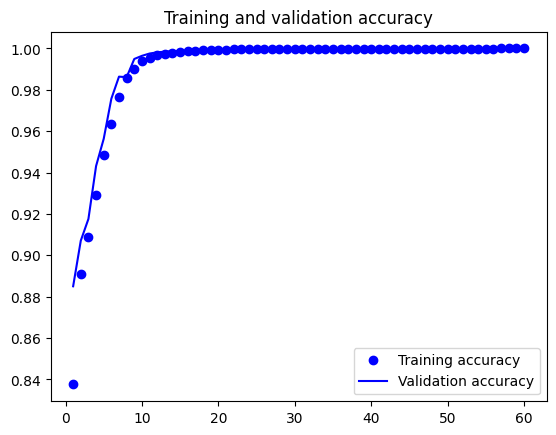

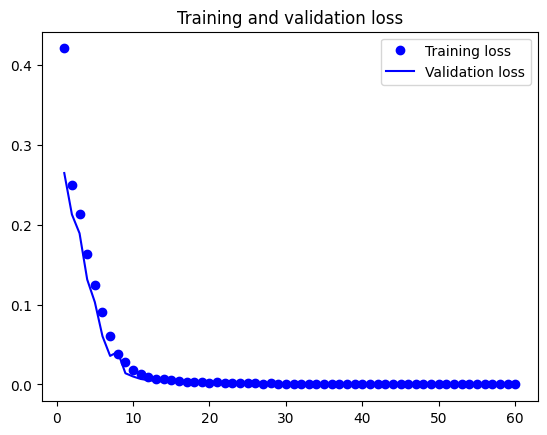

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

>Saving:

In [ ]:
# from google.colab import files
# files.download('Trail0.keras')

>Evaluate:

In [55]:

saved_model = load_model('HSS')                  # load the saved model
accurcy = saved_model.evaluate(test_ds, verbose=0)[1]  # evaluate the model
print('Accurcy = ', (accurcy)*100)

Accurcy =  97.21255898475647


Translating new sentences with our RNN encoder and decoder:

In [56]:
import numpy as np
out_vocab = target_vectorization.get_vocabulary()                 # target_vectorization is for output, see above
out_index_lookup = dict(zip(range(len(out_vocab)), out_vocab))    # convert the words to dic
max_decoded_sentence_length = sequence_length

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"

    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = saved_model.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = out_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence



# test_eng_texts = [pair[0] for pair in test_pairs]   # input text samples
# for _ in range(2):
#     input_sentence = random.choice(test_eng_texts)  # chose random sample
#     print("-")
#     print('input = ',input_sentence)
#     print('output=',decode_sequence(input_sentence))          # transalte this sample



test_inp_texts = [pair[0] for pair in test_pairs]   # input text samples
test_out_texts = [pair[1] for pair in test_pairs]   # output text samples

for j in range(3):
    index=random.randint(0,len(test_inp_texts))
    index=j
    input_sentence =test_inp_texts[index]  # chose random sample
    output_sentance=test_out_texts[index]
    Prediction=decode_sequence(input_sentence)
    print("-")
    print('Target    =',output_sentance)                        # Actual transaltion
    print('Prediction=',Prediction)                             # Prediction



1/1 [==============================] - 0s 38ms/step
-
Target    = [start] c f b d a e e c f c f b d a g h i a d g j a e k a h d f l  [end]
Prediction= [start] c d b d a e e c d c d b f a g h i a d g j a e k a h d f l [end]
1/1 [==============================] - 0s 50ms/step
-
Target    = [start] c f c f a e e c g a d f g a f d h a e i c e a f j k a e l  [end]
Prediction= [start] c d c d a e e c d a f f g a d d h a e i c d a f j k a e l [end]
1/1 [==============================] - 0s 49ms/step
-
Target    = [start] b d c e c f b d a f f g b d a d h i a f e j a g d k  [end]
Prediction= [start] b d c d b e c d a f f g b d a f h i a d e j a g d k [end]


---

**To test the model:**



1.   If the test data set is given as separate input and output. You need to pair and prepare them for translation as follows (uncomment all lines). However, you need to run all code cells in this notebook (except bulding and training the RNNs model) before running the next code cell.


2.   If the test data is ready and processed, you can run the following code cell to test the model without uncommenting any line.










In [26]:

import pickle
import os, shutil, pathlib
import tensorflow as tf

path0 = pathlib.Path("/content/Train_input")   # replace DS_5_train_input by the the name of the input of your data
path1 = pathlib.Path("/content/Train_output")
# Uplaod
input=pickle.load(open(path0, 'rb'))
output=pickle.load(open(path1, 'rb'))

text_pairs = []
for inp,out in zip(input,output):
    out = "[start] " + out + " [end]"    # adding [start] and [end] to output language
    text_pairs.append((inp, out))

batch_size = 64
def format_dataset(inpu, outp):
    inpu = source_vectorization(inpu)     # INPUT
    outp = target_vectorization(outp)     # OUTPUT
    return ({
        "INPUT": inpu,                   # we use the name so we can seperate the source and past_target (see the next 2 cells)
        "OUTPUT": outp[:, :-1],
    }, outp[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

test_ds= make_dataset(text_pairs)




## Evaluation

from keras.models import load_model
Model = load_model('HSS')                    # load the saved model
accurcy = Model.evaluate(test_ds, verbose=0)[1]    # evaluate the model
print('Accurcy = ', (accurcy)*100)                 # Accurcy


Accurcy =  97.21396565437317


In [ ]:
import os
import shutil
from google.colab import files

# Path to the folder you want to download
folder_path = '/content/HSS'

# Name of the zip file you want to create
zip_name = 'HSS'

# Ensure the folder exists
if os.path.exists(folder_path):
    # Create a zip file of the folder
    shutil.make_archive(zip_name, 'zip', folder_path)

    # Check if the zip file was created successfully
    if os.path.exists(f"{zip_name}.zip"):
        # Download the zip file
        files.download(f"{zip_name}.zip")
    else:
        print(f"Failed to create the zip file: {zip_name}.zip")
else:
    print(f"The folder {folder_path} does not exist.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Test** (only test inputs)

In [10]:
!unzip /content/HSS.zip -d /content/HSS/


Archive:  /content/HSS.zip
replace /content/HSS/keras_metadata.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [36]:
import pickle
import tensorflow as tf

# Load the model
from keras.models import load_model
model = load_model('HSS')

# Replace 'Test_input_1000' with the actual path to your test input file
path_to_test_input = '/content/Test_input_1000'

# Load test data
with open(path_to_test_input, 'rb') as f:
    test_input = pickle.load(f)
batch_size = 64
# Prepare the dataset
def make_dataset(inputs):
    # No need to process outputs since we're predicting
    inputs = list(inputs)
    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    dataset = dataset.batch(batch_size)
    # Only mapping the inputs without outputs
    dataset = dataset.map(lambda inp: {'INPUT': source_vectorization(inp)}, num_parallel_calls=4)
    return dataset.cache().prefetch(tf.data.AUTOTUNE)

# Assuming `source_vectorization` is already defined and loaded
# Create the test dataset
test_ds = make_dataset(test_input)

In [57]:
import random
import pickle

# Assuming 'saved_model' is your loaded model and 'source_vectorization', 'target_vectorization' are defined and loaded

# Function to decode a single sequence
def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"

    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = saved_model.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = out_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence.strip("[start]").strip("[end]").strip()

# Load your test data - replace this path with the actual path to your input data
with open('/content/Test_input_1000', 'rb') as file:
    test_inp_texts = pickle.load(file)


# Decode all the sentences
decoded_sentences = [decode_sequence(sentence) for sentence in test_inp_texts]

# Save the output to a file
output_path = '/content/Test_output.pkl'  # Replace with your desired output file path
pickle.dump(decoded_sentences, open(output_path, 'wb'))

# Print the first 10 translations as a sanity check
for prediction in decoded_sentences[:10]:
    print(prediction)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 64ms/step
b d b d b d b d b d a h f g h a d e i a f d j c d a d k l
b d c d b d b f a h e f g a f d h c d b e a h i j k
c d b d c d b d c d a f g h a g f i a f e j a f d k c d a d l m
c d c d a g d e b d a e g b d a h f h i c d a g j k b d c d a e ed a g m ee a f l ef
b d b d b d c d c d a e h c d b f a h i j k a e l a f g m a h e f ed c d a h d ee ef a e eg
c d b d c d a g e f a f d g b d b d a f i j a d h k
c d a e d b d b d a f f g b d a e i a e j b d a h h k l c d a h e m ed a e ee
b d b d c d a e f b d b d a f h i a g g j a f e k a e l b d a h d m ed
c d b d b d c d b e a h f g h a f e i a g d j c d a d k l
b d c d c d b e c d a h f g h b d a e j c d a e l a e m a g k ed a d i ee a d e ef a f d eg


In [37]:
print(test_ds)

<_PrefetchDataset element_spec={'INPUT': TensorSpec(shape=(None, 100), dtype=tf.int64, name=None)}>


In [ ]:
# Assuming `test_ds` is the dataset you want to predict on

# Get the serving signature for prediction
serving_signature = model.signatures['serving_default']
print(model.signatures)

# Assuming the 'OUTPUT' tensor needs to be of the same type and shape as 'INPUT'
def predict(dataset):
    predictions = []
    for batch in dataset:
        # Create a dummy OUTPUT tensor with the same shape and type as INPUT
        dummy_output = tf.zeros_like(batch['INPUT'])
        # Provide both INPUT and dummy OUTPUT tensors
        prediction = infer(INPUT=batch['INPUT'], OUTPUT=dummy_output)
        predictions.append(prediction)
    return predictions

# Run predictions on the test dataset
#predicted_outputs = predict(test_ds)
predicted_outputs = model.predict(test_ds)

In [ ]:
print(predicted_outputs)

In [ ]:
# Check the structure of the prediction to find the right key
if predicted_outputs:
    first_batch_prediction = predicted_outputs[0]
    # Assuming 'dense' is the key that contains the prediction tensor
    if 'dense' in first_batch_prediction:
        prediction_tensor = first_batch_prediction['dense']
        print("Shape of the predictions for the first batch:", prediction_tensor.shape)
    else:
        # If 'dense' is not the correct key, print the keys to find out the correct one
        print("Keys in the prediction dictionary:", first_batch_prediction.keys())



Shape of the predictions for the first batch: (64, 100, 21)


In [ ]:
import numpy as np

def get_most_likely_indices(predictions):
    # We will store the indices of the most likely words here
    all_indices = []

    # Iterate over all the batch predictions
    for batch in predictions:
        # Assuming the key that contains the prediction tensor is 'dense'
        # And that the prediction tensor shape is (batch_size, sequence_length, vocabulary_size)
        prediction_tensor = batch['dense']

        # Find the index of the maximum value in the last dimension (vocabulary_size)
        most_likely_indices = np.argmax(prediction_tensor, axis=-1)

        # Append the indices for this batch to the all_indices list
        all_indices.extend(most_likely_indices)

    return all_indices

# Retrieve the most likely indices from the predictions
most_likely_indices = get_most_likely_indices(predicted_outputs)

# Flatten the list of indices if it's nested
flat_indices = [index for sublist in most_likely_indices for index in sublist]

# Get the first 1000 indices as an example
first_1000_indices = flat_indices[:1000]

# These indices are the model's predictions for the most likely word at each position
# Without the vocabulary mapping, we can't translate these to words
print(first_1000_indices)



[5, 2, 5, 2, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2, 5, 2, 5, 5, 5, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 9, 9, 9, 9, 7, 7, 7, 7, 0, 0, 0, 2, 2, 3, 3, 

In [ ]:
# Function to decode a single sequence
def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"

    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = model.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = out_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence


In [ ]:
# # Decode all input texts
# decoded_texts = []
# for input_text in predicted_outputs[:1000]:  # Limit to the first 1000 inputs
#     prediction = decode_sequence(input_text)
#     decoded_texts.append(prediction)

# for i, decoded_text in enumerate(decoded_texts[:10]):
#     print(f"Input: {test_inp_texts[i]}")
#     print(f"Translated: {decoded_text}")
#     print("-" * 50)

# Function to convert prediction tensor to a string
# You need to implement this based on how your model's predictions can be interpreted
def tensor_to_string(tensor):
    # Example implementation (You need to replace this with actual logic)
    # This is a placeholder and might not work with your specific model
    return ' '.join([str(np.argmax(t)) for t in tensor.numpy()])

# Decode all input texts
decoded_texts = []
for prediction_dict in predicted_outputs[:1000]:  # Limit to the first 1000 inputs
    prediction_tensor = prediction_dict['dense']  # Assuming 'dense' is the key for the prediction tensor
    prediction_string = tensor_to_string(prediction_tensor)
    decoded_text = decode_sequence(prediction_string)
    decoded_texts.append(decoded_text)


for i, decoded_text in enumerate(decoded_texts[:1000]):
    print(f"Translated: {decoded_text}")
    print("-" * 50)


1/1 [==============================] - 0s 46ms/step
Translated: [start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]
--------------------------------------------------
Translated: [start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]
--------------------------------------------------
Translated: [start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]
--------------------------------------------------
Translated: [start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]
--------------------------------------------------
Translated: [start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]
--------------------------------------------------
Translated: [start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]
--------------------------------------------------
Translated: [start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]
--------------------------------------------------
Translated: [start] b d c e b d c f a g f g b

In [ ]:
import pickle



# Specify the file path where you want to save the list
path = '/content/Test_output'

# Use pickle to save the list to the file
with open(path, 'wb') as file:
    pickle.dump(decoded_texts, file)

print("Decoded texts saved successfully.")


Decoded texts saved successfully.


In [ ]:
import pickle

# Specify the file path where the data was saved
path = '/content/Test_output'

# Load the data back into a variable
with open(path, 'rb') as file:
    loaded_data = pickle.load(file)

# Now, loaded_data contains the same list as decoded_texts
print(loaded_data)

['[start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]', '[start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]', '[start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]', '[start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]', '[start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]', '[start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]', '[start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]', '[start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]', '[start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]', '[start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]', '[start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]', '[start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]', '[start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]', '[start] b d c e b d c f a g f g b d c e a h h i j a h d e k [end]', '[start] b d c e b d c f a g f g 